## Train model - Final

In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [1]:
# Install required libs
!pip install albumentations==0.4.6
!pip install segmentation-models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


2.1.0
2.3.1


# Loading dataset

In [3]:
# To mount dataset from Google Drive, use code below

fileId = '1FGFKfTsn7SUSpaU2o75-QBVD6uluyeff'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

if not os.path.exists('dataset'):
  os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Successfuly extracted zip file ' + fileName)

Successfuly extracted zip file 1FGFKfTsn7SUSpaU2o75-QBVD6uluyeff.zip


In [4]:
%cd /content/dataset
DATA_DIR = 'chronsite_images'

/content


In [9]:
x_train_dir = os.path.join(DATA_DIR, 'images')
y_train_dir = os.path.join(DATA_DIR, 'masks')

# Dataloader and utility functions 

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        #plt.xticks([])
        #plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        #class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
        train_val_split: percentage split between train and val images
        data: 'val' or 'train', to select which dataset to build
    
    """
        
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            #classes=None, 
            augmentation=None, 
            preprocessing=None,
            train_val_split=0.1,
            data='train'
    ):
        
        filenames = os.listdir(images_dir)
        random.Random(5).shuffle(filenames)
        if data=='val':
            self.ids = filenames[:int(len(filenames) * train_val_split)]
        elif data=='train':
            self.ids = filenames[int(len(filenames) * train_val_split):-int(len(filenames) * train_val_split)]
        elif data=='test':
            self.ids = filenames[-int(len(filenames) * train_val_split):]
        print(f'{len(self.ids)} images in {data} dataset')
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps_formworks = [os.path.join(masks_dir, image_id[:-4] + '_formworks.png') for image_id in self.ids]
        self.masks_fps_pumps = [os.path.join(masks_dir, image_id[:-4] + '_pumps.png') for image_id in self.ids]

        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_formworks = cv2.imread(self.masks_fps_formworks[i], 0)
        mask_pumps = cv2.imread(self.masks_fps_pumps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        masks = [mask_formworks, mask_pumps]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [14]:
# Lets look at the data we have
dataset = Dataset(x_train_dir, y_train_dir, data='train')

2065 images in train dataset


In [15]:
image, mask = dataset[100] # get some sample
print(mask.shape)

(1024, 1280, 3)


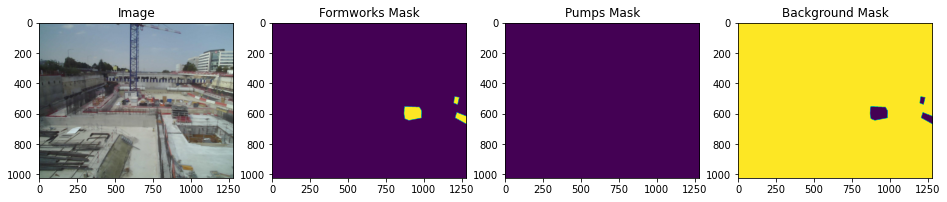

In [16]:
visualize(
    image=image, 
    formworks_mask=mask[..., 0].squeeze(),
    pumps_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

### Augmentations

We apply a set of augmentations with [**Albumentations**](https://github.com/albu/albumentations/). We define strong augmentations for training (`get_training_augmentations()`), and simple preprocessing augmentations (padding and resizing) for testing (`get_testing_agmentations()`).


In [13]:
import albumentations as A

# set image height and width for resizing/padding
WIDTH = 1024
HEIGHT = 768

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.0625, p=0.5, border_mode=0),

        A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        A.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.2),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
                A.RandomBrightness(p=1)
            ],
            p=0.5,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

# define simple augmentations and preprocessing

def get_testing_augmentation():
    test_transform = [
        A.PadIfNeeded(HEIGHT, WIDTH, p=1.0, border_mode=0),
        A.Resize(height=HEIGHT, width=WIDTH, p=1.0)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

2065 images in train dataset


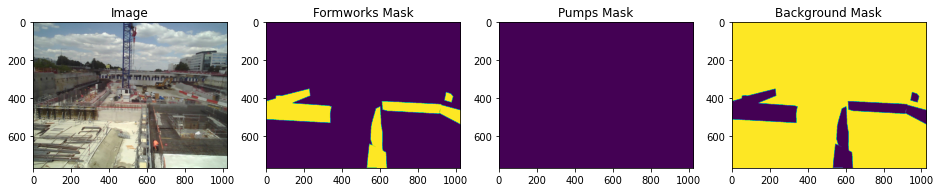

In [19]:
# Lets look at the augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, data='train', augmentation=get_testing_augmentation())

image, mask = dataset[2] # get some sample
visualize(
    image=image, 
    formworks_mask=mask[..., 0].squeeze(),
    pumps_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

* Test: apply augmentations to a single image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2065 images in train dataset


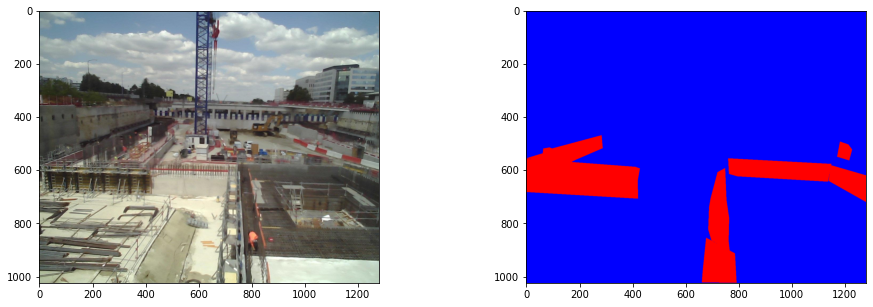

In [20]:
dataset_exp = Dataset(x_train_dir, y_train_dir, data='train')

img=dataset_exp[2][0]
msk=dataset_exp[2][1]

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(img);
plt.subplot(122)
plt.imshow(msk);

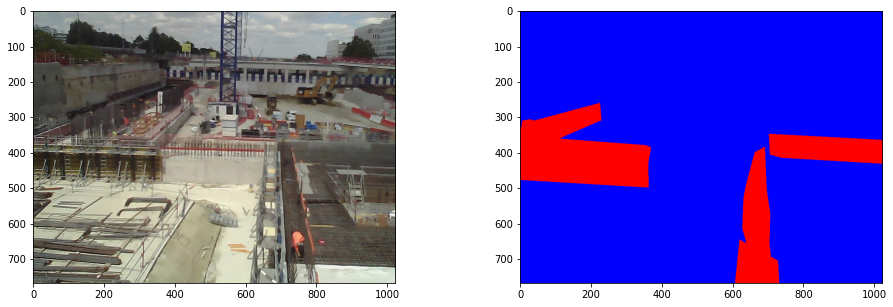

In [21]:
sample = get_training_augmentation()(image=img, mask=msk)
img2, msk2 = sample['image'], sample['mask']

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(img2);
plt.subplot(122)
plt.imshow(msk2);

# Segmentation model training

In [7]:
#%env SM_FRAMEWORK=tf.keras 
# as EfficientNet works with tf.keras but not with keras>2.3

import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [8]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['formworks', 'pumps']
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_freeze=True)

44113920/44107200 [==============================] - 1s 0us/step


In [25]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (formworks: 0.35; pumps: 0.65; background: 0.;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1., 2., 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
# or 
# total_loss = sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics
model.compile(optim, total_loss, metrics)

In [26]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    #classes=CLASSES,
    data='train',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    #classes=CLASSES,
    data='val',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=True)

# check shapes for errors
#assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 1024, 3)
#assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 1024, n_classes)

2065 images in train dataset
258 images in val dataset


In [28]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=True, 
                                    monitor='val_iou_score', mode='max'),
    keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', factor=0.1)
]

In [29]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),
)

Epoch 1/10
1032/1032 [==============================] - 727s 704ms/step - loss: 0.7420 - iou_score: 0.3901 - f1-score: 0.4543 - val_loss: 0.8486 - val_iou_score: 0.4349 - val_f1-score: 0.4885
Epoch 2/10
1032/1032 [==============================] - 687s 665ms/step - loss: 0.6374 - iou_score: 0.4761 - f1-score: 0.5444 - val_loss: 0.8364 - val_iou_score: 0.6592 - val_f1-score: 0.7103
Epoch 3/10
1032/1032 [==============================] - 684s 662ms/step - loss: 0.6015 - iou_score: 0.4923 - f1-score: 0.5588 - val_loss: 0.8360 - val_iou_score: 0.5386 - val_f1-score: 0.5875
Epoch 4/10
1032/1032 [==============================] - 686s 665ms/step - loss: 0.5879 - iou_score: 0.5044 - f1-score: 0.5697 - val_loss: 0.8338 - val_iou_score: 0.4817 - val_f1-score: 0.5335
Epoch 5/10
1032/1032 [==============================] - 686s 665ms/step - loss: 0.5754 - iou_score: 0.5193 - f1-score: 0.5823 - val_loss: 0.8334 - val_iou_score: 0.5673 - val_f1-score: 0.6149
Epoch 6/10
1032/1032 [==================

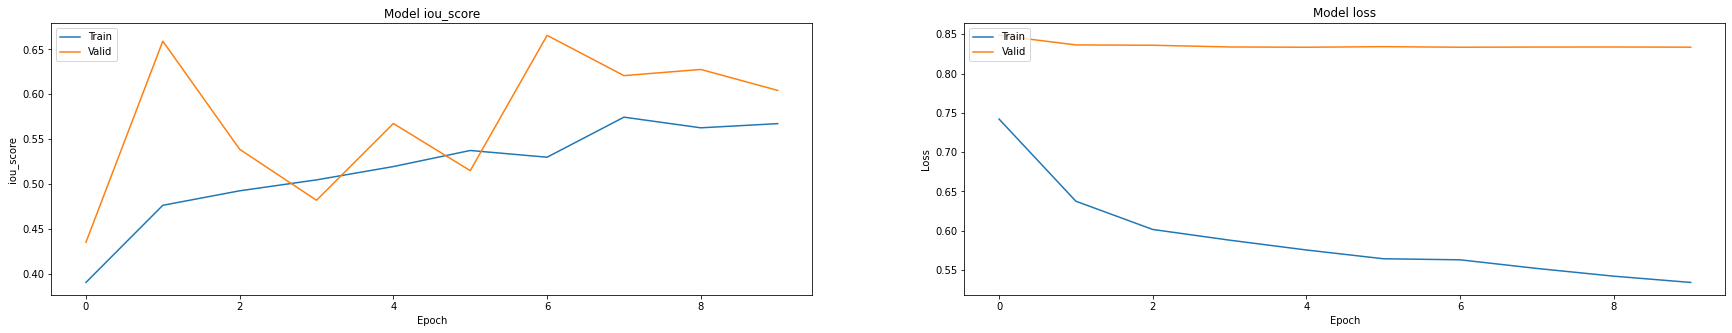

In [30]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

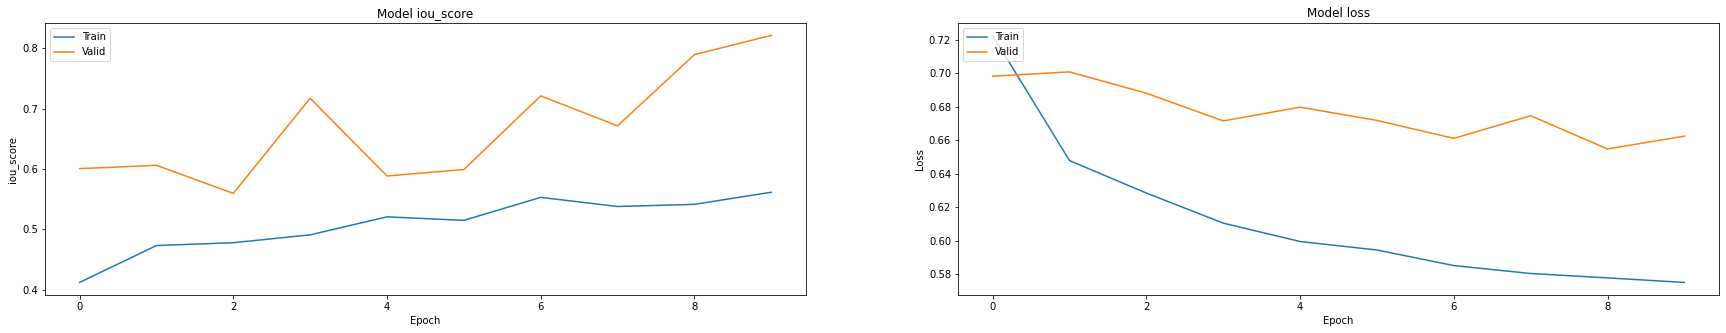

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


# Model Evaluation

In [15]:
test_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    #classes=CLASSES,
    data='test', 
    augmentation=get_testing_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

158 images in test dataset


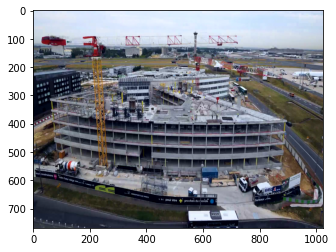

In [32]:
# show sample image from test_dataset
img=test_dataset[2][0]
plt.imshow(denormalize(img));

In [ ]:
# load best model
#model.load_weights('../best_weights.h5')
#model_test = keras.models.load_model('../best_model.h5')

In [36]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

258/258 [==============================] - 43s 168ms/step
Loss: 0.83341
mean iou_score: 0.60024
mean f1-score: 0.64766


In [ ]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

258/258 [==============================] - 40s 157ms/step - loss: 0.6609 - iou_score: 0.7701 - f1-score: 0.8123
Loss: 0.66088
mean iou_score: 0.77011
mean f1-score: 0.81225


# Visualization of results on test dataset

(1, 768, 1024, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


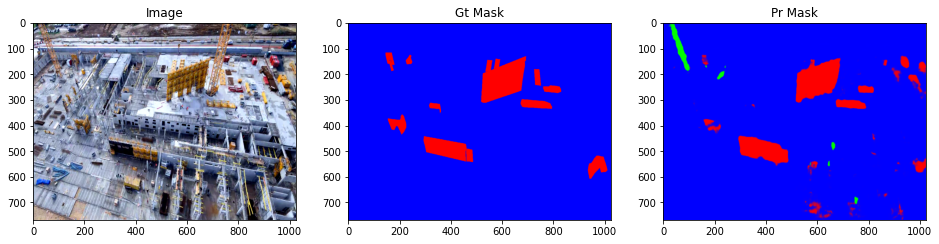

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


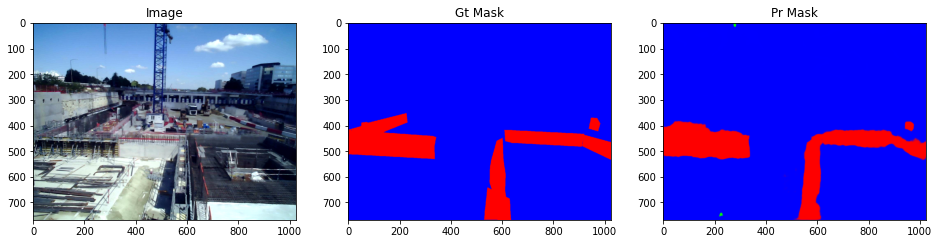

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


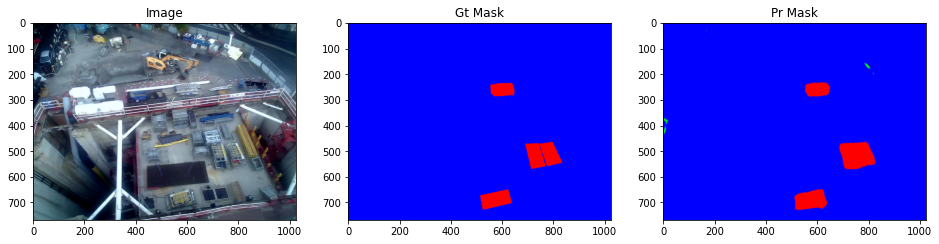

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


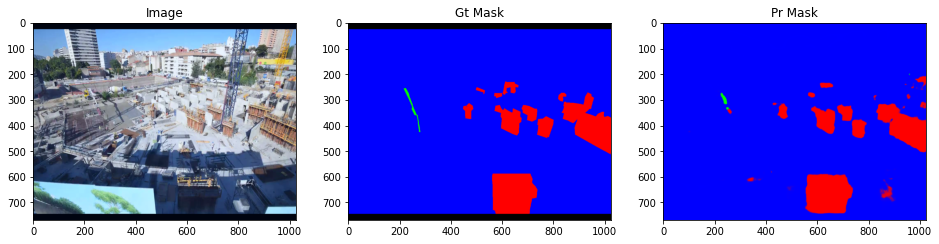

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


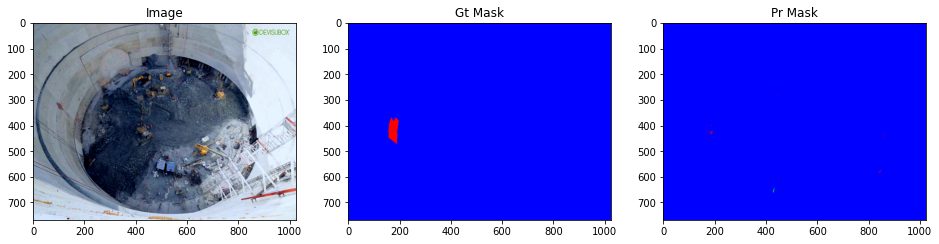

In [34]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    print(image.shape)
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

## Load model from scratch and test again to compare results

In [19]:
model2 = keras.models.load_model("../models/best_model_0410.h5", compile=False)

ValueError: Unknown layer: Functional

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


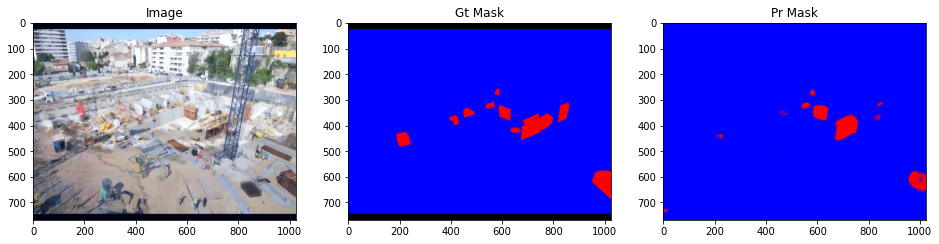

(1, 768, 1024, 3)


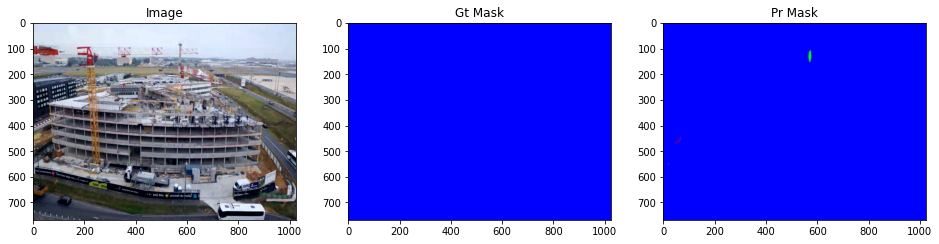

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


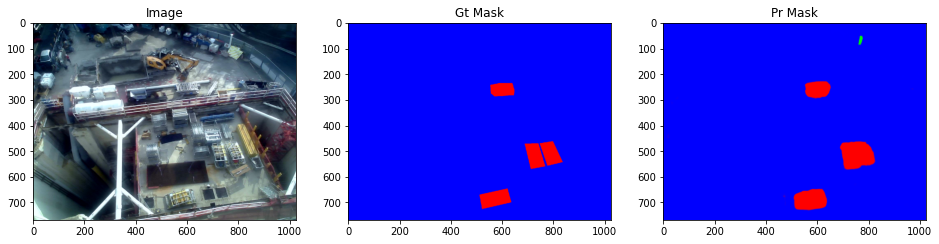

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


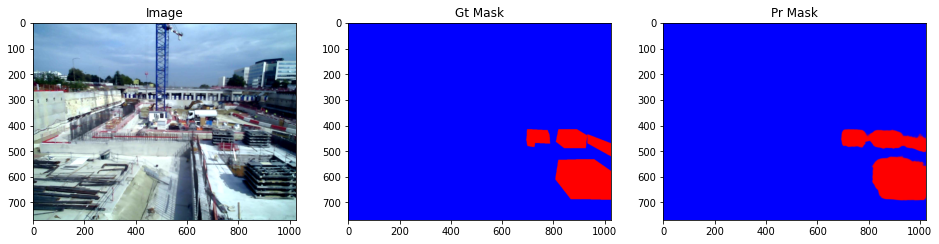

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 768, 1024, 3)


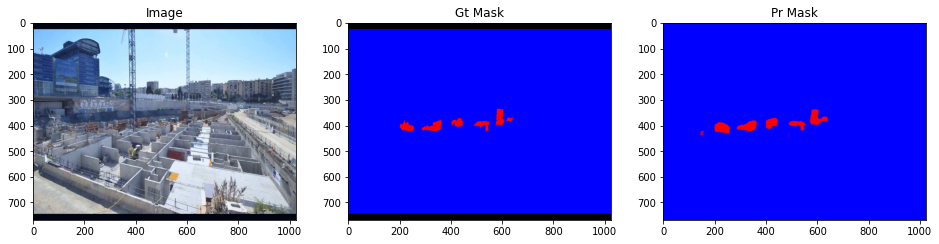

In [46]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model2.predict(image)
    print(image.shape)
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

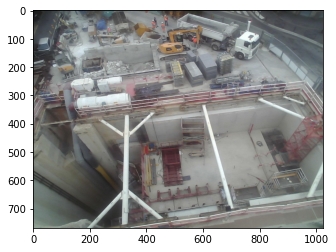

In [63]:
# single image detection

import skimage
from skimage import io

# Read the image as a numpy array and resize it
image = 'chronsite_images/images/2020_07_20_07_03_08.jpg'
image = skimage.io.imread(image, plugin='matplotlib')
if image.shape[-1] == 4: # remove alpha channel
    image = image[..., :3]
transform = A.Compose([
    A.PadIfNeeded(768, 1024, p=1.0, border_mode=0),
    A.Resize(height=768, width=1024, p=1.0)])
transformed = transform(image=image)
image = transformed["image"]
plt.imshow(image);

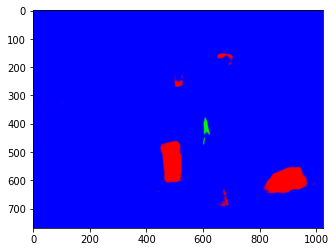

In [64]:
# Apply UNet/EfficientNet preprocessing
preprocess_input = sm.get_preprocessing(BACKBONE)
_transform = A.Compose([A.Lambda(image=preprocess_input)])
sample = _transform(image=image)
image_preprocessed = sample['image']

# Run detection and plot predicted mask
image = np.expand_dims(image_preprocessed, axis=0)
pr_mask = model2.predict(image)
pr_mask = pr_mask.squeeze()
plt.imshow(pr_mask);